In [1]:
import pandas as pd
import ast
import statistics
import matplotlib.pyplot as plt
import numpy as np
import numpy
import tables
from scipy.stats import spearmanr
from nltk.corpus import cmudict
import nltk.corpus.reader.cmudict
from string import digits
import json
from nltk.tokenize import RegexpTokenizer

In [2]:
def iterate_data(h5_file):
    for x in h5_file.root:
        yield x

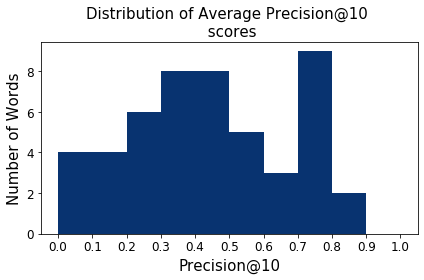

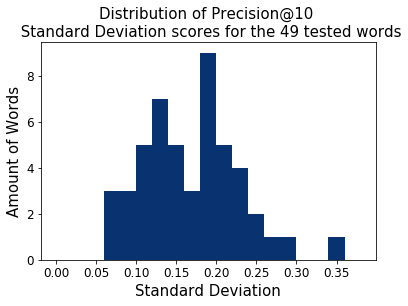

In [44]:
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/Results_isolated_word_recognition/results_forcedalignment_49words.csv"

df = pd.read_csv(path)
df["Testedword"] = df["Tested"].str.replace("flickr_","")
df["Testedword"] = [words.split("_")[0] for words in df["Testedword"]]
df["Results"] = [ast.literal_eval(score) for score in df["Results"]]
df["Precision@10"] = [sum(score)*0.1 for score in df["Results"]]

#words tested
testlist = ["dog","man","boy","girl","woman","people"
            ,"dogs","shirt","child","ball","person"
            ,"children","men","girls","bike","rock","camera"
            ,"boys","hat","player","jacket","basketball","swing"
            ,"car", "wall", "hair","football","sunglasses","head"
            ,"shorts","dress","table","water","grass","bench","snow"
            ,"air","field","street","mouth","dirt","mountain","pool"
            ,"ocean","sand","building","soccer","park","face"]

scorelist = pd.DataFrame()

for word in testlist:
    dflength = len(df[df["Testedword"] == word]["Precision@10"])
    averagescore = df[df["Testedword"] == word]["Precision@10"].sum()/dflength
    stdev = statistics.stdev(list(df[df["Testedword"] == word]["Precision@10"]))
    
    valuesdict = {"Word": word, "AvgScore": averagescore, "Stdev": stdev}
    scorelist = scorelist.append(valuesdict, ignore_index=True)

num_bins = 1

fig, ax = plt.subplots()
n, bins, patches = ax.hist(scorelist["AvgScore"], bins = numpy.arange(0, 1.1, 0.1),color="#083370") 
plt.xticks(numpy.arange(0, 1.1, step=0.1))
ax.set_xlabel('Precision@10')
ax.set_ylabel('Number of Words')
ax.set_title(f"Distribution of Average Precision@10 \n scores")
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)
plt.tight_layout()
plt.savefig('../plots/precision@10testedobjects.png',dpi=1200)

plt.show()

plt.style.use('seaborn-deep')

num_bins = 10
fig, ax = plt.subplots()
n, bins, patches = ax.hist(scorelist["Stdev"], bins = numpy.arange(0, 0.4, 0.02),color="#083370") 
plt.xticks(numpy.arange(0, 0.4, step=0.05))
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Amount of Words')
ax.set_title(f"Distribution of Precision@10 \n Standard Deviation scores for the {len(scorelist)} tested words")

plt.savefig('/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/plots/stdevtestedobjects.png')

plt.show()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

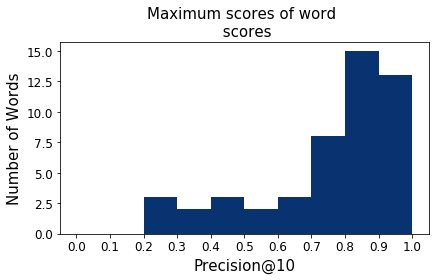

In [46]:
#calculate the highest scores achieved per word
maxscores = pd.DataFrame()
for word in testlist:
    score = df.iloc[df[df["Testedword"]==word]["Precision@10"].idxmax()]["Precision@10"]
    valuesdict = {"Word": word, "maxscore": score}
    maxscores = maxscores.append(valuesdict, ignore_index=True)
fig, ax = plt.subplots()
n, bins, patches = ax.hist(maxscores["maxscore"], bins = numpy.arange(0, 1.1, 0.1),color="#083370") 
plt.xticks(numpy.arange(0, 1.1, step=0.1))
ax.set_xlabel('Precision@10')
ax.set_ylabel('Number of Words')
ax.set_title(f"Maximum scores of word \n scores")
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)
plt.tight_layout()
plt.savefig('../plots/maximumscoresprecision@10testedobjects.png',dpi=1200)

numpy.arange(0, 1, 0.1)


In [4]:
scorelist = scorelist[['Word',"AvgScore","Stdev"]]
path = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/data/Flickr8k_text/Flickr8k.token.txt"
path2 = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/data/dataset.json"
file = json.load(open(path2))
split_dict = {}
arpabet = nltk.corpus.cmudict.dict()
for x in file['images']:
    split_dict[x['filename'].replace('.jpg', '')] = x['split']
    
trainingset = []
for key, value in split_dict.items():
    if value == "train":
        trainingset.append(key)
text = pd.read_csv(path, sep="\t",header=None)
text.columns = ["images","captions"]
textcopy = text
text.images = [words[:-6] for words in text.images if words==words]
text = text[text.images.isin(trainingset)]

text = text["captions"]
tokenizer = RegexpTokenizer(r'\w+')
wordlist = []
for sentence in text:
    sentence = sentence.lower()
    words = tokenizer.tokenize(sentence)
    wordlist.extend(words)
wordlist = [x.lower() for x in wordlist]
sr = pd.Series(wordlist)
worddictionary = dict(sr.value_counts())


scorelist["WordLength"] = [len(word) for word in scorelist["Word"]]
# scorelist["NSyl"] = [nsyl(word)[0] for word in scorelist["Word"]]
scorelist["TrainingSetOccurence"] = [worddictionary[word] for word in scorelist["Word"]]

path ="/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/Generating_Flickrwords_mfcc/mfcc/objects_49words_mfcc_features.h5"

mfccfile = tables.open_file(path, mode="r+")
mfccfile = [node for node in iterate_data(mfccfile)]
wordinstances = pd.DataFrame()

for nodes in mfccfile:
    stringlist = nodes._v_name.split(sep="_")[1:5]
    originalword = nodes._v_name.split(sep="_")[1]
    WordInstance = "_".join(stringlist)
    mfcclength = nodes.mfcc._f_list_nodes()[0].shape[0]
    
    valuesdict = {"WordInstance": WordInstance,"OriginalWord":originalword, "MfccLength": mfcclength}
    wordinstances = wordinstances.append(valuesdict, ignore_index=True)
wordinstances = wordinstances[["WordInstance","OriginalWord","MfccLength"]]

lengthdict = {}
for word in testlist:
    lengthdict[word] = wordinstances[wordinstances["OriginalWord"] == word]["MfccLength"].sum()/len(wordinstances[wordinstances["OriginalWord"] == word])
    
wordinstances["WordAvgMfccLength"] = [lengthdict[word] for word in wordinstances["OriginalWord"]]
for idx,word in enumerate(df["Tested"]):
    stringlist = word.split(sep="_")[1:5]
    joinedword = "_".join(stringlist)
    df["Tested"][idx] = joinedword

wordinstances["Precision@10"] = np.nan

for idx1,string in enumerate(df["Tested"]):
    for idx2,string2 in enumerate(wordinstances["WordInstance"]):
        if string == string2:
            wordinstances["Precision@10"][idx2] = df["Precision@10"][idx1]

scorelist["NofVowels"] = np.nan
scorelist["NofConsonants"] = np.nan

for idx,word in enumerate(scorelist["Word"]):
    vowel = 0
    consonant = 0
    for letter in word:
        if letter in ('a', 'e', 'i', 'o', 'u'):
            vowel = vowel + 1
        else:
            consonant = consonant + 1
    scorelist["NofVowels"][idx] = vowel
    scorelist["NofConsonants"][idx] = consonant

wordinstances["NofPhonemes"] = np.nan
wordinstances["WordLength"] = np.nan
wordinstances['NofVowels'] = np.nan
wordinstances["NofConsonants"] = np.nan

for idx1,string in enumerate(wordinstances["OriginalWord"]):
    remove_digits = str.maketrans('', '', digits)
    x = len([words.translate(remove_digits) for words in arpabet[string][0]])
    wordinstances["NofPhonemes"][idx1] = x 
    for idx2,string2 in enumerate(scorelist["Word"]):
        if string == string2:
            wordinstances["WordLength"][idx1] = scorelist["WordLength"][idx2]
            wordinstances["NofVowels"][idx1] = scorelist["NofVowels"][idx2]
            wordinstances["NofConsonants"][idx1] = scorelist['NofConsonants'][idx2]
            
wordinstances["SpeakingSpeed"] = wordinstances["NofPhonemes"] / wordinstances["MfccLength"]
wordinstances.to_csv("wordinstancesdata.csv",index=False)

/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sebastiaanscholten/opt/anaconda3/envs/merkxmodel/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [137]:
# wordinstances["MfccLengthDeviation"] = wordinstances["MfccLength"] - wordinstances["WordAvgMfccLength"]          
# wordinstances["MfccLengthDeviationNorm"] = wordinstances["MfccLengthDeviation"]/wordinstances["WordAvgMfccLength"]
# coef1,p1 = spearmanr(scorelist["AvgScore"],scorelist["TrainingSetOccurence"])
# coef2,p2 = spearmanr(scorelist["AvgScore"],scorelist["NSyl"])
# coef3,p3 = spearmanr(wordinstances["Precision@10"],wordinstances["MfccLengthDeviationNorm"])
# coef4,p4 = spearmanr(wordinstances["Precision@10"],wordinstances["MfccLength"])
# coef5,p5 = spearmanr(wordinstances["Precision@10"],wordinstances["SpeakingSpeed"])
# coef6,p6 = spearmanr(scorelist["AvgScore"],scorelist["NofConsonants"])
# coef7,p7 = spearmanr(scorelist["AvgScore"],scorelist["NofVowels"])
# coef8,p8 = spearmanr(scorelist["AvgScore"],scorelist["WordLength"])
# print(f"\# of training set occurences & {coef1:.3f} & {p1:.3f} \\\ \hline")
# print(f"\# of syllables & {coef2:.3f} & {p2:.3f} \\\ \hline")
# print(f"\# of consonants & {coef6:.3f} & {p6:.3f}  \\\ \hline")
# print(f"\# number of vowels & {coef7:.3f} & {p7:.3f} \\\ \hline")
# print(f"word length & {coef8:.3f} & {p8:.3f} \\\ \hline")
# print(f"signal length & {coef4:.3f} & {p4:.3f} \\\ \hline")
# print(f"speaking speed & {coef5:.3f} & {p5:.3f} \\\ \hline")
# print(f"\# signal length deviation from word average & {coef3:.3f} & {p3:.3f} \\\ \hline")
